In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data=pd.read_csv('raw_data/BTC_regression_data2.csv',index_col='Date')
data.index=pd.to_datetime(data.index,format='%Y-%m-%d')

In [3]:
data2=data.copy()
date_mask = (data2.index > pd.to_datetime('2017-05-01')) & (data2.index < pd.to_datetime('2020-02-01'))
data2 = data2[date_mask]
data2

,BTC price [USD],Volume BTC,Gold price[USD],Oil WTI price[USD],SP500 close index,BTC n-transactions,M2(Not seasonally adjusted)[1e+09 USD],btc search interest
Date,,,,,,,,
2017-05-02,1471.99,11924.59,1324.0,47.65,2391.17,333161.0,13467.3,15
2017-05-03,1533.00,16309.77,1315.5,47.79,2388.13,333161.0,13467.3,15
2017-05-04,1563.39,26688.81,1295.3,45.55,2389.52,333161.0,13467.3,15
2017-05-05,1551.30,16885.42,1293.7,46.23,2399.29,267193.0,13467.3,15
2017-05-08,1713.00,15881.13,1294.0,46.46,2399.38,365096.0,13467.3,15
...,...,...,...,...,...,...,...,...
2020-01-27,8895.96,9424.43,1589.5,53.09,3243.63,261247.0,15420.9,13
2020-01-28,9394.50,16365.39,1581.7,53.33,3276.24,261247.0,15420.9,13
2020-01-29,9288.44,12035.69,1582.0,53.29,3273.40,340562.0,15420.9,13


In [16]:
features_to_delete=['BTC price [USD]','Volume BTC','BTC n-transactions']

X=data.drop(columns=features_to_delete,axis=1)
y=data['BTC price [USD]']



## Regression tree

In [5]:
depths=np.arange(2,22,1)
RMSE_test=[]
RMSE_train=[]

kf=KFold(n_splits=10, shuffle=True)



for d in depths:
    RMSE_test_temp=[]
    RMSE_train_temp=[]
    for train_index, test_index in kf.split(X):
        model=DecisionTreeRegressor(max_depth=d,min_samples_leaf=2)
        model.fit(X.iloc[train_index,:],y.iloc[train_index])
        y_pred1=model.predict(X.iloc[test_index,:])
        y_pred_train=model.predict(X.iloc[train_index,:])
        RMSE_test_temp.append(mean_squared_error(y_pred1,y.iloc[test_index],squared=False))
        RMSE_train_temp.append(mean_squared_error(y_pred_train,y.iloc[train_index],squared=False))
    RMSE_test.append(np.array(RMSE_test_temp).mean())
    RMSE_train.append(np.array(RMSE_train_temp).mean())

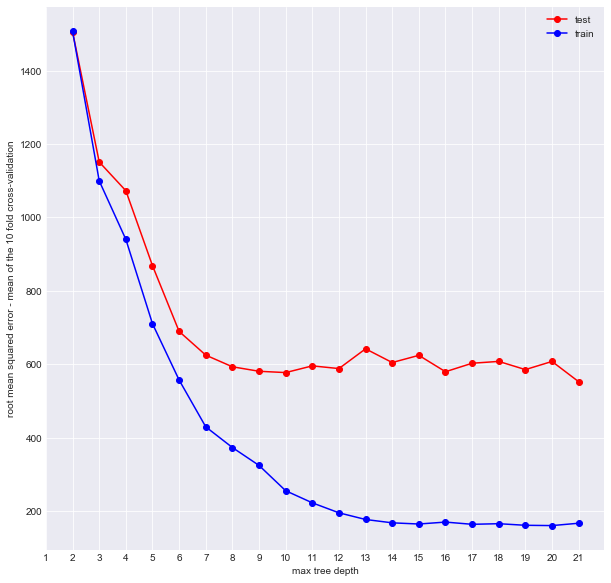

In [6]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10,10))
plt.plot(depths,RMSE_test,'r-o',label='test')
plt.plot(depths,RMSE_train,'b-o',label='train')
plt.xticks(ticks=np.arange(1,22,1))
plt.xlabel('max tree depth')
plt.ylabel('root mean squared error - mean of the 10 fold cross-validation')
plt.legend()


## Random Forest Regression - the whole dataset (2014-2020)

In [17]:
depths=np.arange(2,22,1)
features=np.arange(2,X.shape[1]+1,1)
trees=500
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.8, shuffle=True)

RMSE_res_test=pd.DataFrame(columns=depths,index=features)
RMSE_res_test.columns.name='tree max depth'
RMSE_res_test.index.name='number of feature in random forest'

RMSE_res_train=pd.DataFrame(columns=depths,index=features)
RMSE_res_train.columns.name='tree max depth'
RMSE_res_train.index.name='number of feature in random forest'

for d in depths:
    RMSE_test=[]
    RMSE_train=[]
    for f in features:
        model=RandomForestRegressor(n_estimators=trees,max_depth=d,max_features=f)
        model.fit(X_train,y_train)
        y_pred_test=model.predict(X_test)
        y_pred_train=model.predict(X_train)
        RMSE_test.append(int(mean_squared_error(y_test,y_pred_test,squared=False)))
        RMSE_train.append(int(mean_squared_error(y_train,y_pred_train,squared=False)))
    RMSE_res_test[d]=RMSE_test
    RMSE_res_train[d]=RMSE_train


In [18]:
RMSE_res_test

tree max depth,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
number of feature in random forest,,,,,,,,,,,,,,,,,,,,
2,1550,1240,1027,898,798,778,752,727,752,743,731,742,744,742,751,752,734,740,748,735
3,1484,1141,973,861,801,766,745,751,759,754,754,751,751,756,756,760,754,753,763,760
4,1450,1114,979,877,830,808,793,793,798,793,799,785,790,803,788,797,788,789,788,788
5,1409,1113,1006,906,868,835,834,836,832,829,830,836,841,829,837,841,842,827,835,841


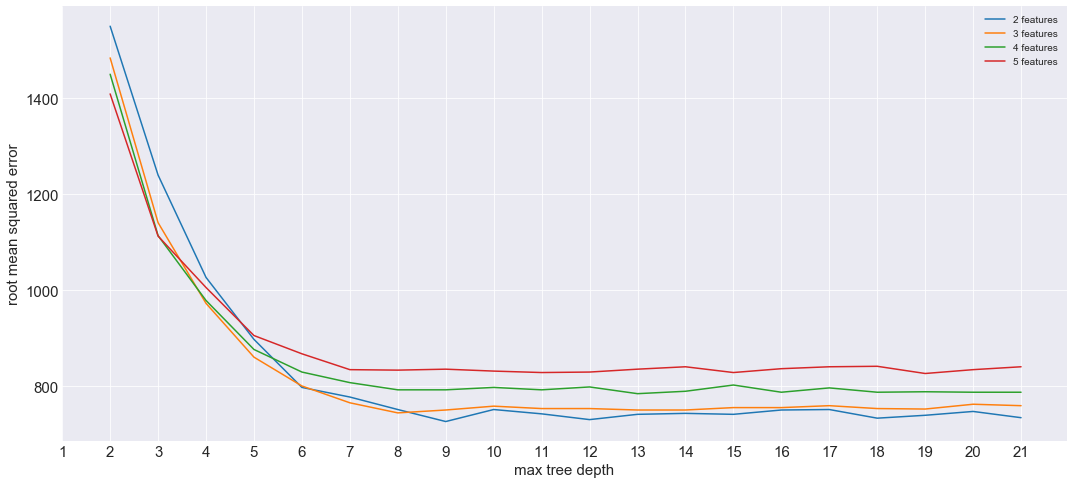

In [19]:
plt.figure(figsize=(18,8))
for i in RMSE_res_test.index:
    plt.plot(depths,RMSE_res_test.loc[i,:],label='{} features'.format(i))
    
plt.xticks(ticks=np.arange(1,22,1),fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('max tree depth',fontsize=15)
plt.ylabel('root mean squared error',fontsize=15)
plt.legend()
plt.show()

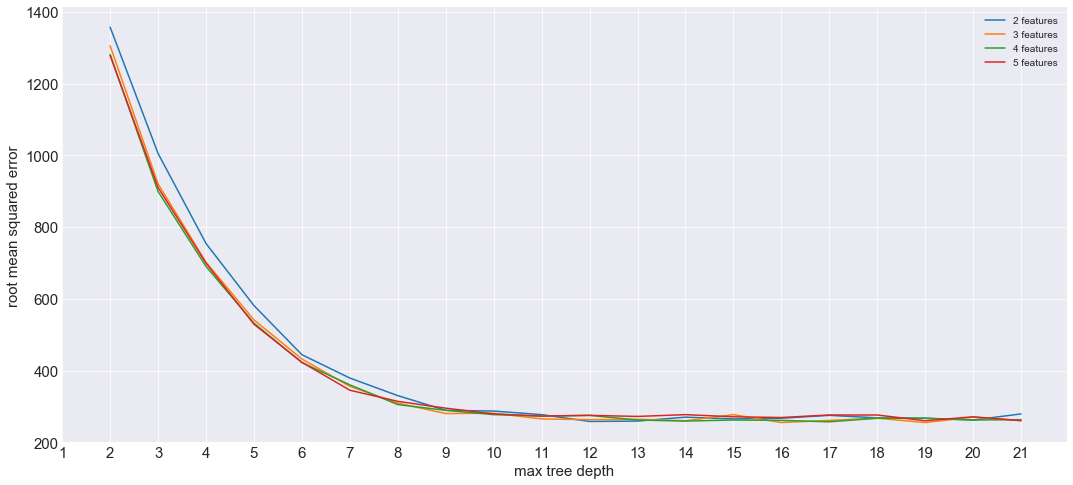

In [20]:
plt.figure(figsize=(18,8))
for i in RMSE_res_train.index:
    plt.plot(depths,RMSE_res_train.loc[i,:],label='{} features'.format(i))
    
plt.xticks(ticks=np.arange(1,22,1),fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('max tree depth',fontsize=15)
plt.ylabel('root mean squared error',fontsize=15)
plt.legend()
plt.show()

### Further examination of random forest regression for max depth d=8 and max feature f=4

In [21]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.5, shuffle=True)

model=RandomForestRegressor(n_estimators=500,max_depth=8,max_features=4)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)



In [22]:
print('features importances')
for idx in model.feature_importances_.argsort():
    print(X.columns[idx],' - ',model.feature_importances_[idx] )


features importances
Oil WTI price[USD]  -  0.01761224711486898
Gold price[USD]  -  0.05906201793389049
btc search interest  -  0.12569416651038742
SP500 close index  -  0.31272829385434125
M2(Not seasonally adjusted)[1e+09 USD]  -  0.48490327458651183


In [41]:
analysis=pd.DataFrame(data=np.hstack( (y_test.values.reshape(-1,1),y_pred.reshape(-1,1))),
             columns=['true price','predicted'],
            index=y_test.index)
analysis.sort_index(inplace=True)
analysis['difference absolute']=abs(analysis['true price']-analysis['predicted'])
analysis['difference']=analysis['true price']-analysis['predicted']
analysis

,true price,predicted,difference absolute,difference
Date,,,,
2014-12-02,378.00,363.471626,14.528374,14.528374
2014-12-03,378.00,364.171067,13.828933,13.828933
2014-12-04,377.10,362.730907,14.369093,14.369093
2014-12-11,360.50,334.962428,25.537572,25.537572
2014-12-15,350.00,312.330627,37.669373,37.669373
...,...,...,...,...
2020-04-22,7136.84,7182.302941,45.462941,-45.462941
2020-04-23,7488.83,7175.224954,313.605046,313.605046
2020-04-28,7755.01,8006.135195,251.125195,-251.125195


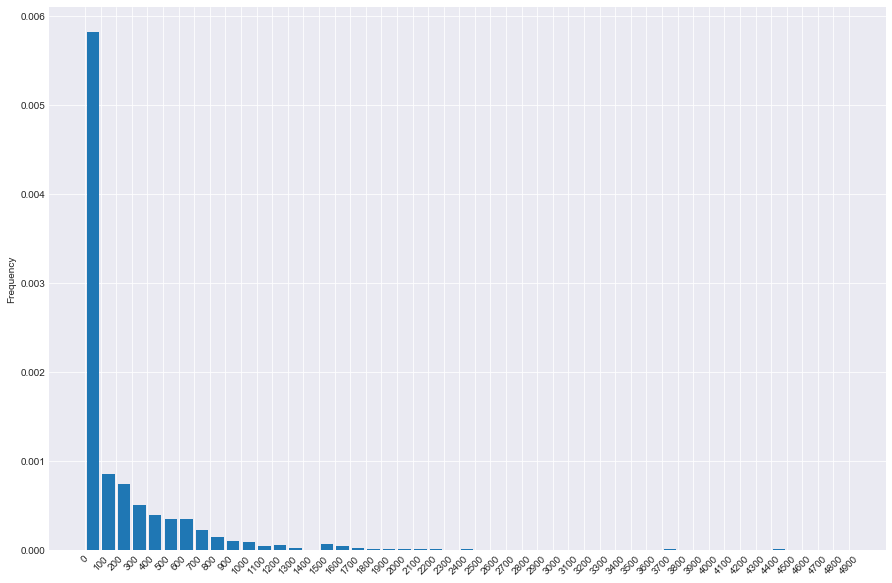

In [42]:
plt.figure(figsize=(15,10))
analysis['difference absolute'].plot(kind='hist',bins=np.arange(0,5000,100),rwidth=0.8,align='mid',density=True)
plt.xticks(ticks=np.arange(0,5000,100),rotation=45)
plt.show()

In [86]:
(analysis['difference absolute']**2).sum()/analysis.shape[0]
# np.sqrt(((analysis['true price']-analysis['predicted'])**2).sum()/analysis.shape[0])

a=analysis['difference absolute'].values
b=np.where(a>1500,0,a)
b=b[b!=0]

np.sqrt((b**2).sum()/b.size)

336.30312030659775

In [44]:
# pd.qcut(analysis['Difference'],4)
analysis['percentage difference']=analysis['difference absolute']/analysis['true price']

In [45]:
def per(x):
    if x>0 and x<=0.1:
        return 1
    elif x>0.1 and x<=0.2:
        return 2
    elif x>0.2 and x<=0.3:
        return 3
    elif x>0.3 and x<=0.4:
        return 4
    elif x>0.4 and x<=0.5:
        return 5
    elif x>0.5 and x<=0.6:
        return 6
    elif x>0.6 and x<=0.7:
        return 7
    elif x>0.7 and x<=0.8:
        return 8
    elif x>0.8 and x<=0.9:
        return 9
    else: return 10
    
    
analysis['percentage discrete']=analysis['percentage difference'].apply(per)

In [46]:
analysis['percentage discrete'].value_counts()

1    565
2     87
3     17
4      4
5      2
Name: percentage discrete, dtype: int64

In [48]:
analysis

,true price,predicted,difference absolute,difference,percentage difference,percentage discrete
Date,,,,,,
2014-12-02,378.00,363.471626,14.528374,14.528374,0.038435,1
2014-12-03,378.00,364.171067,13.828933,13.828933,0.036584,1
2014-12-04,377.10,362.730907,14.369093,14.369093,0.038104,1
2014-12-11,360.50,334.962428,25.537572,25.537572,0.070839,1
2014-12-15,350.00,312.330627,37.669373,37.669373,0.107627,2
...,...,...,...,...,...,...
2020-04-22,7136.84,7182.302941,45.462941,-45.462941,0.006370,1
2020-04-23,7488.83,7175.224954,313.605046,313.605046,0.041876,1
2020-04-28,7755.01,8006.135195,251.125195,-251.125195,0.032382,1
